# Additional  Insights

---
**Group 2:**

- Luis Mendes 20221949
- Margarida Ourives 20221809
- Simon Sazonov 20221689 
- Veronica Mendes 20221945
---

### **Abstract**
Here we want to test  whether  the  best  performance  is  achieved  using  a  general  model(trained using data from all brands/models, etc...) or pecific brands


**Table of contents**<a id='toc0_'></a> 
- [Imports](#toc2_)    
- [Data Integration](#toc3_)    
- [Modeling](#toc4_)    
    - [Benchmarking](#toc4_1_1_)    
    - [Random Forest](#toc4_1_2_)    
    - [Final Model](#toc4_1_3_)    
- [Deployment](#toc5_)    
    - [Pipeline Test Set](#toc5_1_1_)    
    - [Prediction](#toc5_1_2_)    

<!-- vscode-jupyter-toc-config
    numbering=false
    anchor=true
    flat=false
    minLevel=1
    maxLevel=6
    /vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[Imports](#toc0_)

In [4]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Grid Search
from sklearn.model_selection import ParameterGrid
# Progress
from tqdm import tqdm
# Spliting
from sklearn.model_selection import KFold
# Preprocessing
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
# Imputation
from sklearn.impute import KNNImputer
# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# Evaluation Metrics
from sklearn.metrics import mean_absolute_error
# CV Score and Graphing
from utils import (avg_scores,
                   graph_actual_vs_predicted, 
                   model_performance, 
                   grid_score, 
                   print_cv_results)

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set_context("notebook")
sns.set_style("ticks")

In [7]:
# Load your cleaned (NOT encoded/scaled) dataset
X_CV, y_CV = pd.read_pickle('../project_data/X_Ylog_ModelOptimization.pkl')

# Ensure indexes match
X_CV = X_CV.reset_index(drop=True)
y_CV = y_CV.reset_index(drop=True)

brands = X_CV['Brand'].unique()
brands = np.sort(brands)

brand_preprocessed = {}   # store all objects and preprocessed data

for brand in brands:
    print(f"--- Processing brand: {brand} ---")
    
    # 1. Extract brand-specific rows
    mask = (X_CV['Brand'] == brand)
    X_b = X_CV.loc[mask].reset_index(drop=True).copy()
    y_b = y_CV.loc[mask].reset_index(drop=True).copy()
    
    # Drop Brand for preprocessing
    X_b_no_brand = X_b.drop(columns=['Brand'])
    
    # 2. Train/validation split for brand (local)
    from sklearn.model_selection import train_test_split
    Xb_train, Xb_test, yb_train, yb_test = train_test_split(
        X_b_no_brand, y_b, test_size=0.20, random_state=42
    )
    
    # ===============================
    # Step 3A — Fit transmission mode
    # ===============================
    if 'transmission' in Xb_train.columns:
        transmission_mode = Xb_train['transmission'].mode()[0]
    else:
        transmission_mode = None
    
    if transmission_mode is not None:
        Xb_train['transmission'] = Xb_train['transmission'].fillna(transmission_mode)
        Xb_test['transmission']  = Xb_test['transmission'].fillna(transmission_mode)
    
    # ===============================
    # Step 3B — Fit OneHotEncoder
    # ===============================
    ohe = OneHotEncoder(
        categories=[['automatic', 'manual', 'semi-auto']],
        drop=['automatic'],
        handle_unknown='ignore',
        sparse_output=False,
        dtype=int
    )
    
    preproc = ColumnTransformer(
        transformers=[
            ('enc_trans', ohe, ['transmission'])
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
    preproc.set_output(transform='pandas')
    
    # Fit on TRAIN only
    Xb_train_enc = preproc.fit_transform(Xb_train)
    Xb_test_enc  = preproc.transform(Xb_test)
    
    # ===============================
    # Step 3C — Fit RobustScaler
    # ===============================
    scaler = RobustScaler()
    Xb_train_scaled = scaler.fit_transform(Xb_train_enc)
    Xb_test_scaled  = scaler.transform(Xb_test_enc)
    
    # ===============================
    # Step 3D — Fit KNNImputer
    # ===============================
    imputer = KNNImputer(n_neighbors=10, weights='uniform')
    Xb_train_imp = imputer.fit_transform(Xb_train_scaled)
    Xb_test_imp  = imputer.transform(Xb_test_scaled)
    
    # Convert back to DataFrames + reattach brand
    Xb_train_final = pd.DataFrame(Xb_train_imp, columns=Xb_train_enc.columns)
    Xb_test_final  = pd.DataFrame(Xb_test_imp, columns=Xb_test_enc.columns)
    
    Xb_train_final['Brand'] = brand
    Xb_test_final['Brand']  = brand
    
    # ===============================
    # Store everything in dictionary
    # ===============================
    brand_preprocessed[brand] = {
        'X_train': Xb_train_final,
        'X_test':  Xb_test_final,
        'y_train': yb_train,
        'y_test':  yb_test,
        'encoder': preproc,
        'scaler':  scaler,
        'imputer': imputer,
        'transmission_mode': transmission_mode
    }

--- Processing brand: audi ---
--- Processing brand: bmw ---
--- Processing brand: ford ---
--- Processing brand: hyundai ---
--- Processing brand: mercedes ---
--- Processing brand: opel ---
--- Processing brand: skoda ---
--- Processing brand: toyota ---
--- Processing brand: vw ---


Sample count per brand:


,Brand,Samples
2,ford,15673
4,mercedes,11382
8,vw,10121
5,opel,9134
1,bmw,7214
0,audi,7147
7,toyota,4519
6,skoda,4194
3,hyundai,3261


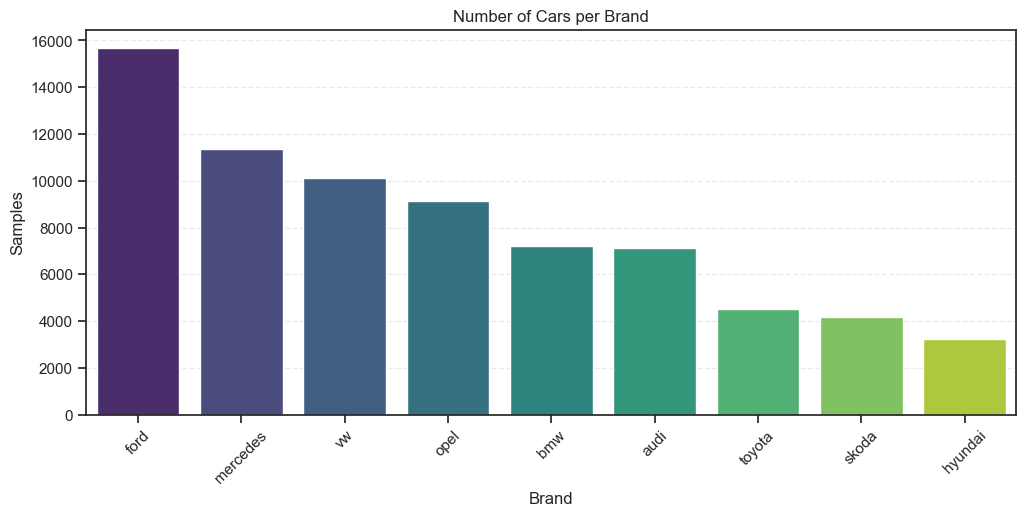

In [23]:
brand_sizes = {brand: brand_preprocessed[brand]['X_train'].shape[0] + 
                         brand_preprocessed[brand]['X_test'].shape[0]
               for brand in brand_preprocessed}

brand_sizes_df = pd.DataFrame({
    'Brand': list(brand_sizes.keys()),
    'Samples': list(brand_sizes.values())
}).sort_values('Samples', ascending=False)

print("Sample count per brand:")
display(brand_sizes_df)

# Bar plot
plt.figure(figsize=(12,5))
sns.barplot(data=brand_sizes_df, x='Brand', y='Samples', palette='viridis')
plt.title("Number of Cars per Brand")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


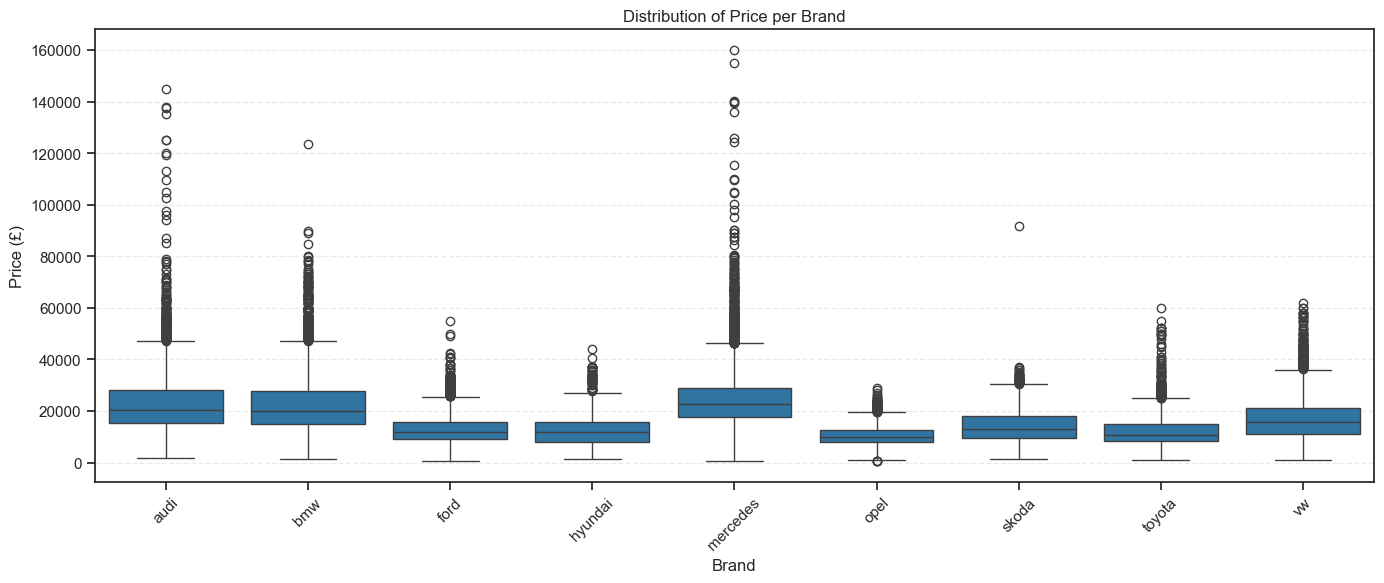

In [28]:
plt.figure(figsize=(14,6))
# Build DataFrame from brand y_train Series (Series -> DataFrame with column 'price')
df_prices = pd.concat(
    [pd.DataFrame({'price': brand_preprocessed[b]['y_train']}).assign(Brand=b) for b in brands],
    axis=0
).reset_index(drop=True)

# Convert from log-price back to original price scale
import numpy as np
df_prices['price'] = np.exp(df_prices['price'])

sns.boxplot(data=df_prices, x='Brand', y='price')
plt.title("Distribution of Price per Brand")
plt.ylabel('Price (£)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

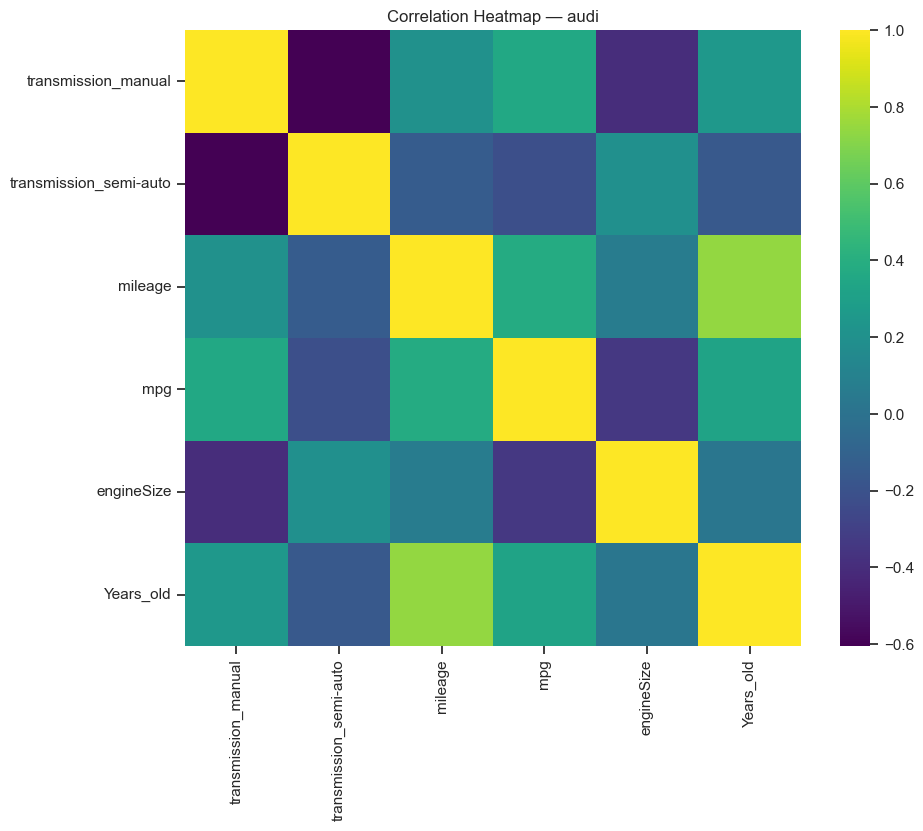

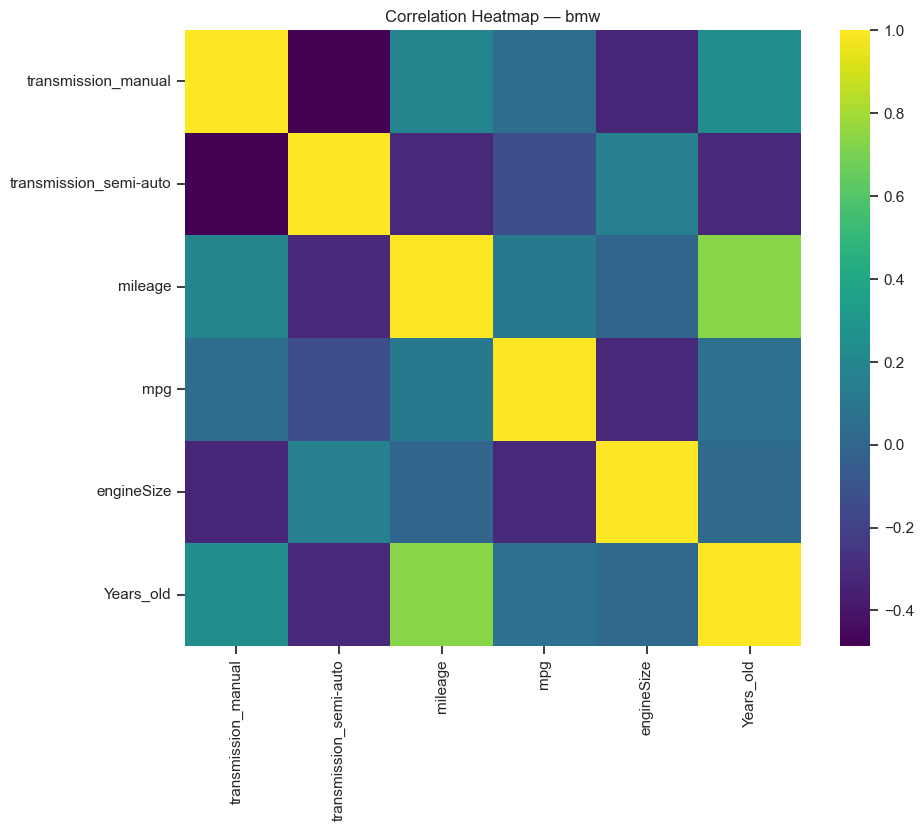

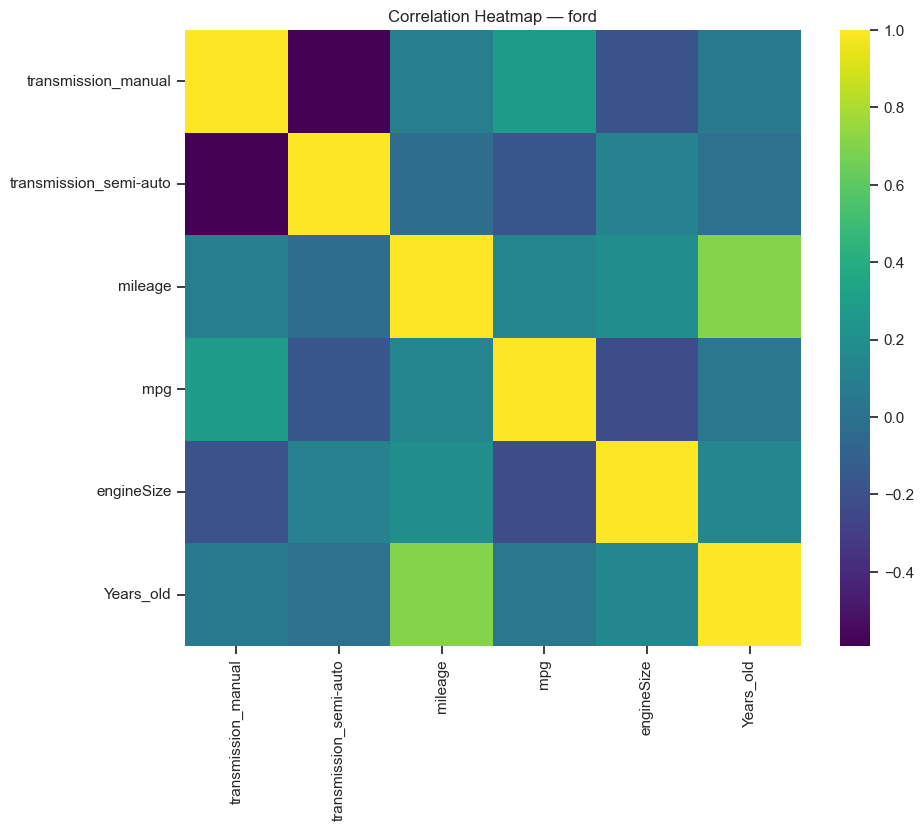

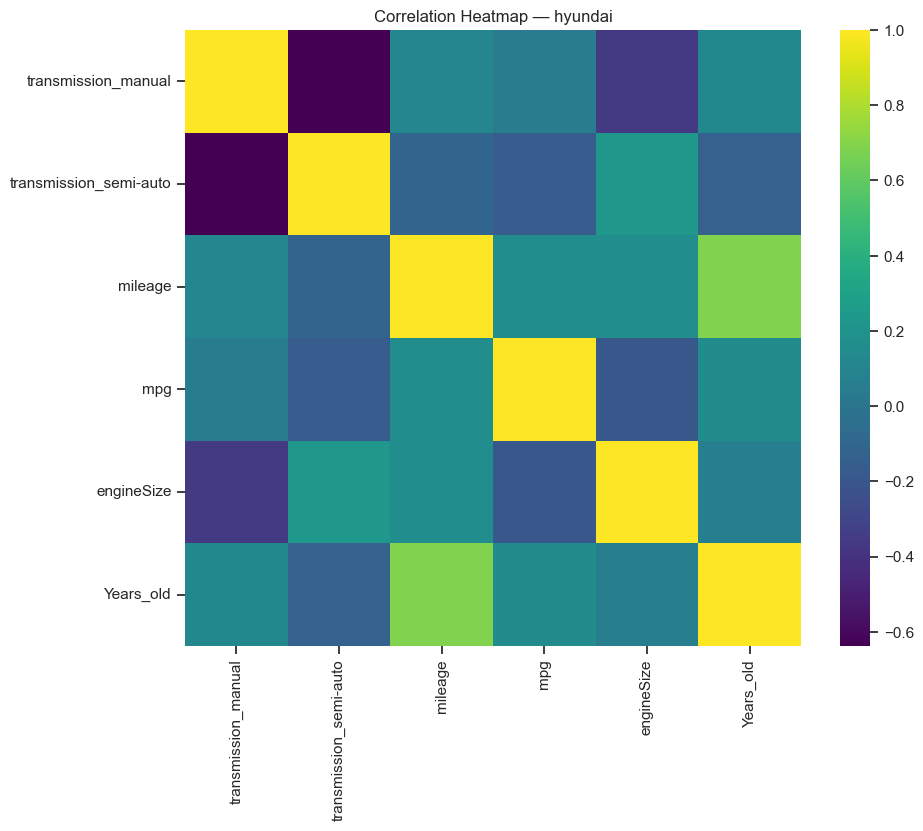

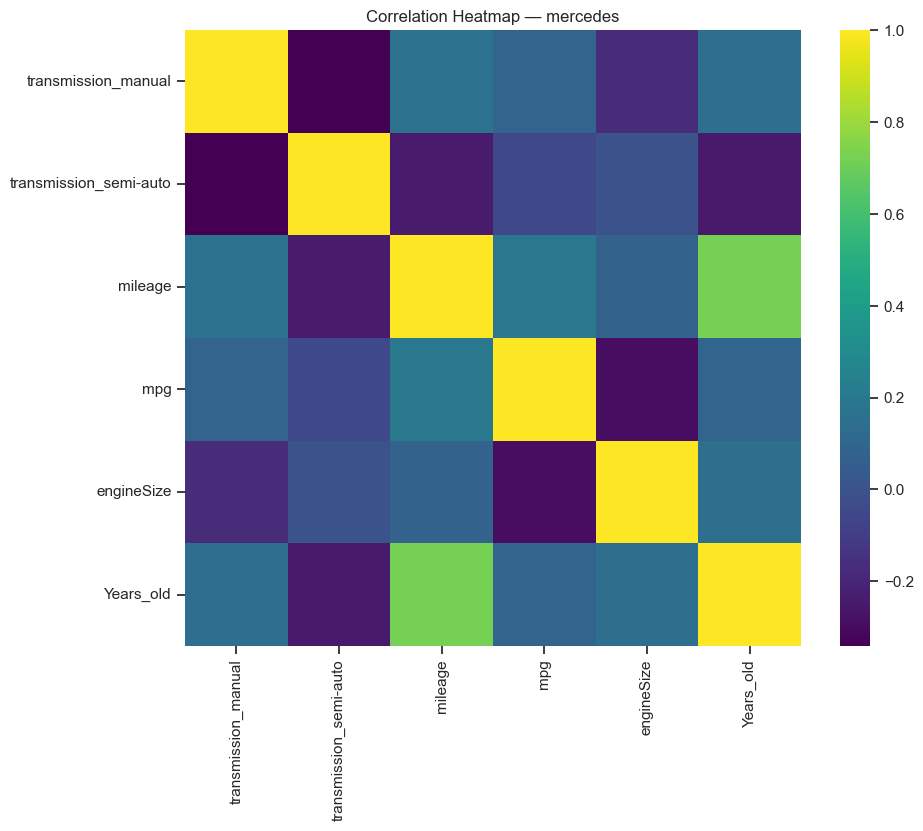

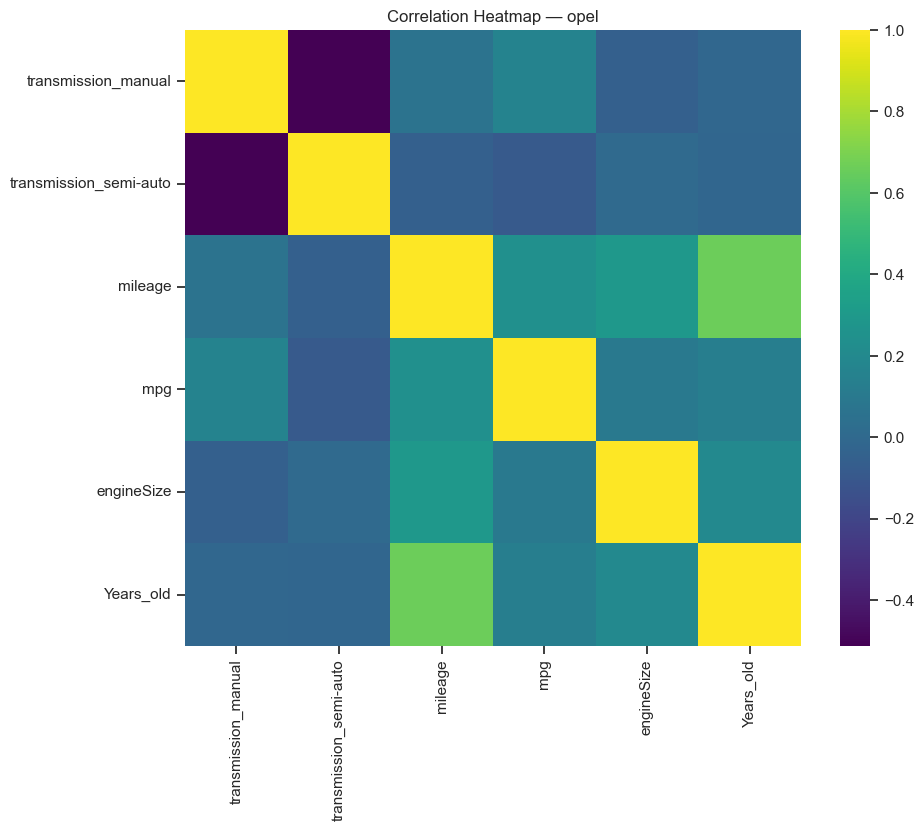

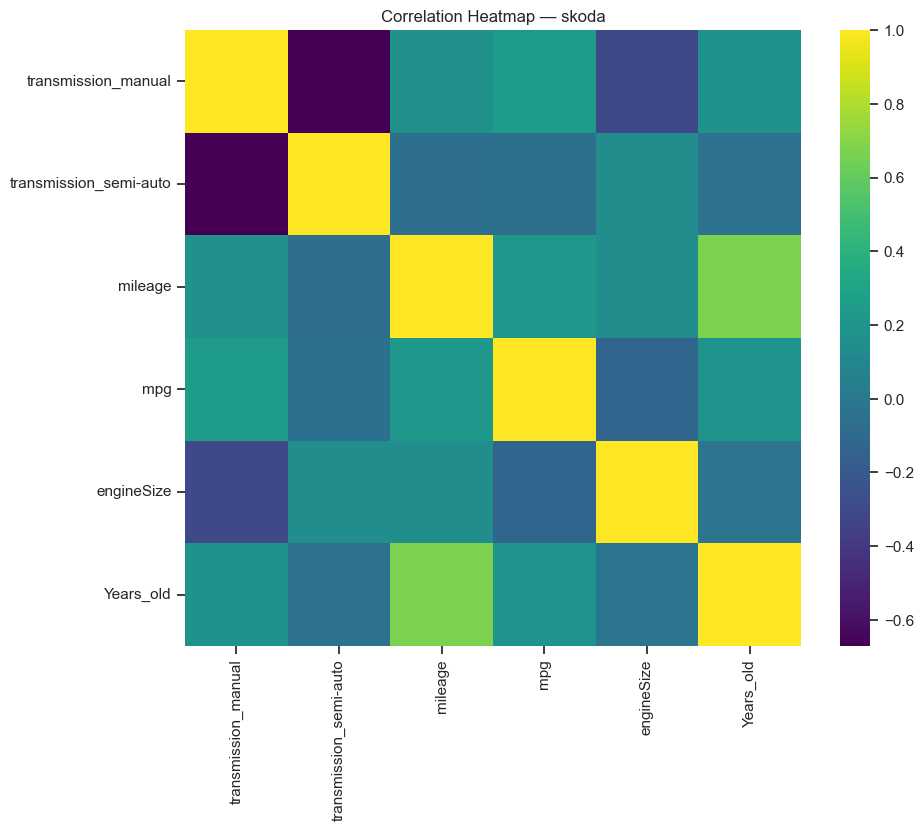

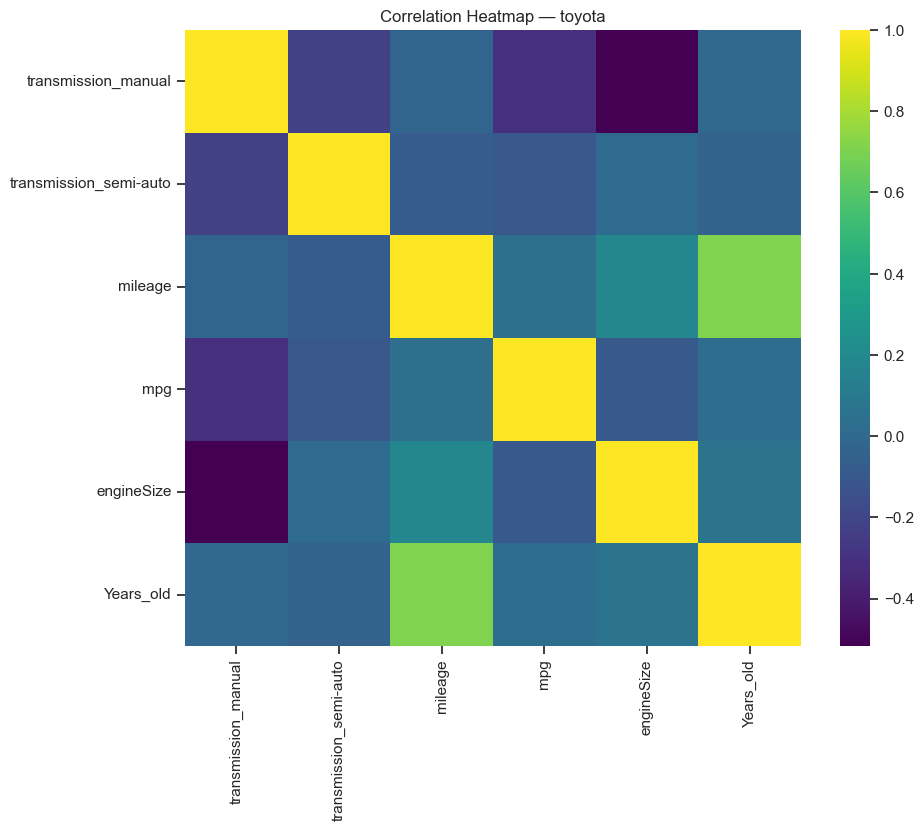

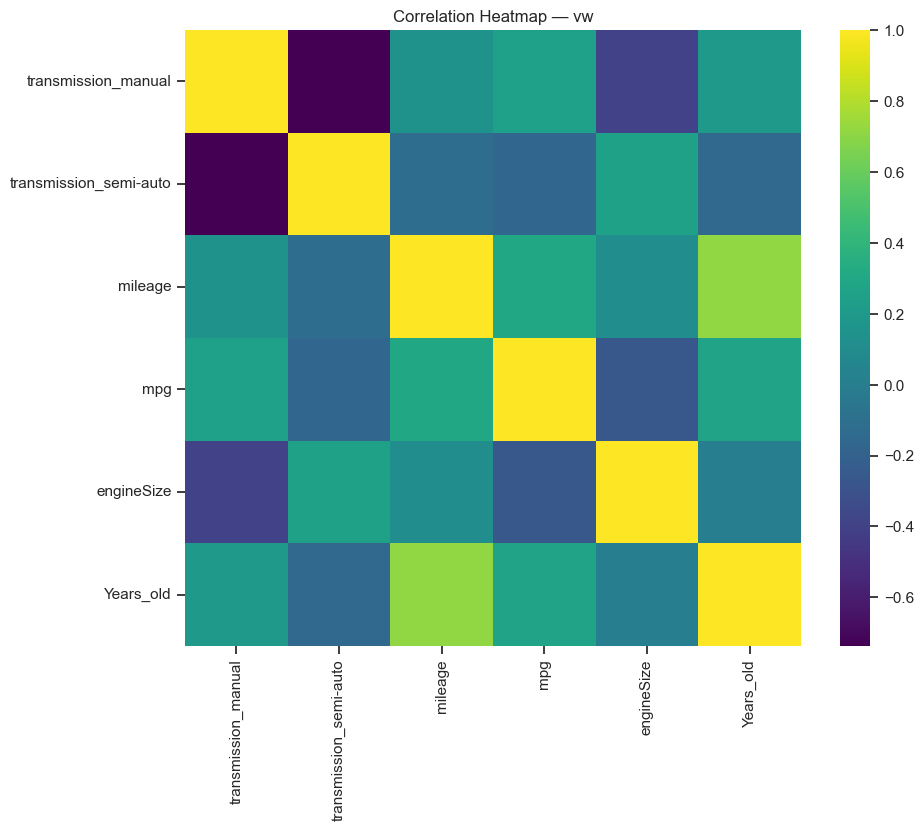

In [29]:
for brand in brands:
    df = brand_preprocessed[brand]['X_train'].drop(columns=['Brand'])
    
    plt.figure(figsize=(10,8))
    sns.heatmap(df.corr(), annot=False, cmap='viridis', square=True)
    plt.title(f"Correlation Heatmap — {brand}")
    plt.show()

# KNN

In [ ]:
# Storage for all brand results
brand_knn_results = {}

# Define your search range (based on global analysis)
param_grid = {'n_neighbors': list(range(7, 101))}

for brand in brands:
    print(f"\n==============================")
    print(f" Running KNN Grid Search for → {brand}")
    print(f"==============================")

    # Load ORIGINAL raw data for this brand (not the preprocessed version)
    mask = (X_CV['Brand'] == brand)
    X_brand_raw = X_CV.loc[mask].reset_index(drop=True).copy()
    y_brand_raw = y_CV.loc[mask].reset_index(drop=True).copy()
    
    # Drop Brand column for modeling
    X_brand_raw = X_brand_raw.drop(columns=['Brand'])

    # Train/test split on raw data
    from sklearn.model_selection import train_test_split
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_brand_raw, y_brand_raw, test_size=0.20, random_state=42
    )

    # Dictionaries to store scores
    dic_train = {}
    dic_val = {}

    # Grid Search on preprocessed data ----------------------------------------
    # For grid search, we use the preprocessed train/test sets
    X_train = brand_preprocessed[brand]['X_train'].drop(columns=['Brand'])
    X_test  = brand_preprocessed[brand]['X_test'].drop(columns=['Brand'])

    for params in tqdm(ParameterGrid(param_grid)):
        k = params['n_neighbors']

        model = KNeighborsRegressor(
            n_neighbors=k,
            weights='uniform',
            n_jobs=-1
        )

        # Use your scoring function
        grid_score(
            x_train = X_train,
            y_train = y_train,
            x_val   = X_test,
            y_val   = y_test,
            model   = model,
            score_train_dic = dic_train,
            score_val_dic   = dic_val,
            dic_key = ('KNN', k),
            log_transform = True
        )

    # Find best k (lowest validation MAE)
    best_k = min(dic_val, key=dic_val.get)[1]
    best_val_mae = dic_val[('KNN', best_k)]
    best_train_mae = dic_train[('KNN', best_k)]
    overfit_gap = best_val_mae - best_train_mae

    print(f"Best k for {brand}: {best_k}")
    print(f"Validation MAE: {best_val_mae:.2f}")
    print(f"Overfitting gap: {overfit_gap:.2f}")

    # -----------------------------------------------------------------------
    # Cross-Validation using your pipeline parts
    # -----------------------------------------------------------------------

    # CV scoring dictionaries (for consistency)
    dic_train_cv = {}
    dic_val_cv = {}

    # Create KFold object for cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Use the raw data for CV since avg_scores() expects to do preprocessing
    avg_scores(
        X = X_train_raw,
        y = y_train,
        CV = kfold,
        imputer = KNNImputer(n_neighbors=10, weights='uniform'),
        scalar = RobustScaler(),
        model = KNeighborsRegressor(n_neighbors=best_k, weights='uniform', n_jobs=-1),
        score_train_dic = dic_train_cv,
        score_val_dic   = dic_val_cv,
        dic_key = f'KNN_{brand}',
        log_transform = True
    )

    print_cv_results(f'KNN_{brand}', dic_train_cv, dic_val_cv)

    # Store all results
    brand_knn_results[brand] = {
        'best_k': best_k,
        'train_MAE': best_train_mae,
        'val_MAE': best_val_mae,
        'overfitting_gap': overfit_gap,
        'cv_train_mae': dic_train_cv[f'KNN_{brand}'][0],
        'cv_val_mae': dic_val_cv[f'KNN_{brand}'][0],
        'encoder': brand_preprocessed[brand]['encoder'],
        'scaler': brand_preprocessed[brand]['scaler'],
        'imputer': brand_preprocessed[brand]['imputer']
    }


 Running KNN Grid Search for → audi


100%|██████████| 94/94 [00:09<00:00,  9.86it/s]


Best k for audi: 7
Validation MAE: 2350.76
Overfitting gap: 367.07


5it [00:00,  7.22it/s]



CV Results - KNN_audi
Train MAE: 2032.08, Train std: 14.63
Validation MAE: 2356.99, Validatin std: 26.26

 Running KNN Grid Search for → bmw


100%|██████████| 94/94 [00:10<00:00,  9.01it/s]


Best k for bmw: 8
Validation MAE: 2734.78
Overfitting gap: 386.09


5it [00:00,  6.33it/s]



CV Results - KNN_bmw
Train MAE: 2397.33, Train std: 15.13
Validation MAE: 2762.04, Validatin std: 44.12

 Running KNN Grid Search for → ford


100%|██████████| 94/94 [00:19<00:00,  4.75it/s]


Best k for ford: 9
Validation MAE: 1074.48
Overfitting gap: 81.80


5it [00:12,  2.41s/it]



CV Results - KNN_ford
Train MAE: 1012.23, Train std: 4.39
Validation MAE: 1138.81, Validatin std: 9.84

 Running KNN Grid Search for → hyundai


100%|██████████| 94/94 [00:05<00:00, 17.64it/s]


Best k for hyundai: 7
Validation MAE: 1152.82
Overfitting gap: 174.27


5it [00:00, 13.94it/s]
5it [00:00, 13.94it/s]


CV Results - KNN_hyundai
Train MAE: 1007.14, Train std: 9.52
Validation MAE: 1170.2, Validatin std: 50.27

 Running KNN Grid Search for → mercedes


100%|██████████| 94/94 [00:20<00:00,  4.50it/s]


Best k for mercedes: 7
Validation MAE: 2544.29
Overfitting gap: 332.82


5it [00:05,  1.20s/it]



CV Results - KNN_mercedes
Train MAE: 2270.16, Train std: 16.35
Validation MAE: 2645.18, Validatin std: 96.25

 Running KNN Grid Search for → opel


100%|██████████| 94/94 [00:13<00:00,  7.23it/s]


Best k for opel: 9
Validation MAE: 934.23
Overfitting gap: 85.25


5it [00:01,  3.33it/s]



CV Results - KNN_opel
Train MAE: 863.96, Train std: 5.62
Validation MAE: 966.65, Validatin std: 42.0

 Running KNN Grid Search for → skoda


100%|██████████| 94/94 [00:08<00:00, 11.42it/s]


Best k for skoda: 8
Validation MAE: 1457.87
Overfitting gap: 188.23


5it [00:00,  9.47it/s]



CV Results - KNN_skoda
Train MAE: 1302.72, Train std: 20.62
Validation MAE: 1491.58, Validatin std: 66.79

 Running KNN Grid Search for → toyota


100%|██████████| 94/94 [00:06<00:00, 15.29it/s]


Best k for toyota: 7
Validation MAE: 1170.23
Overfitting gap: 212.75


5it [00:00, 11.52it/s]



CV Results - KNN_toyota
Train MAE: 992.73, Train std: 8.38
Validation MAE: 1176.47, Validatin std: 40.35

 Running KNN Grid Search for → vw


100%|██████████| 94/94 [00:17<00:00,  5.47it/s]


Best k for vw: 7
Validation MAE: 1689.99
Overfitting gap: 250.73


5it [00:01,  3.53it/s]

CV Results - KNN_vw
Train MAE: 1480.27, Train std: 13.3
Validation MAE: 1746.64, Validatin std: 67.65


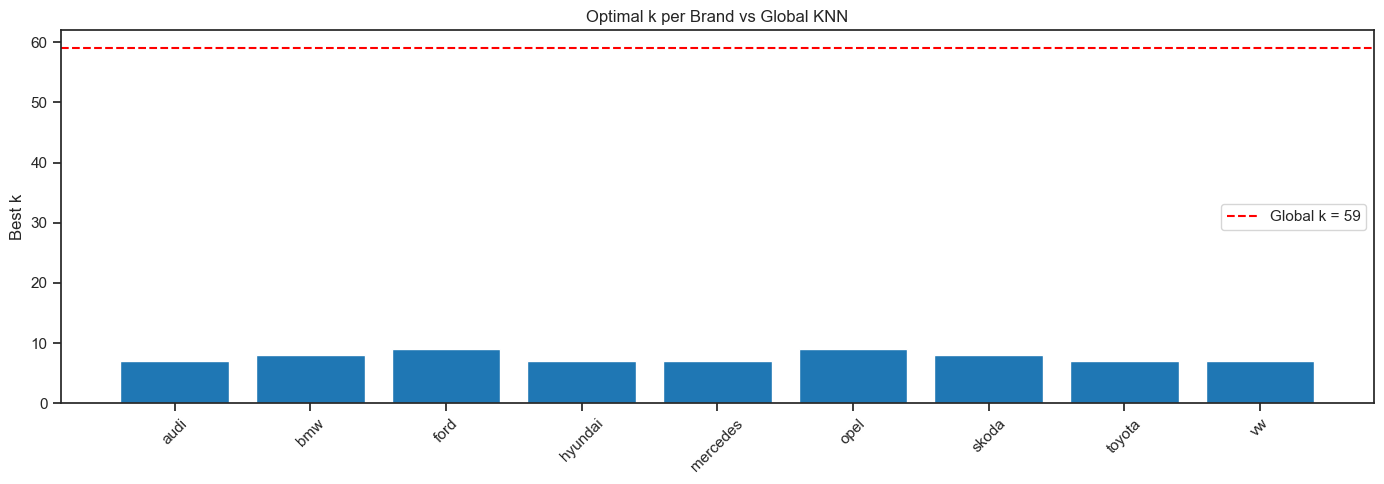

In [19]:
global_k = 59 # From modeling the whole data not dividing by brands global k value
global_val_mae = 2458.21 # From global modeling
global_cv_val_mae = 2503.57  # From global modeling
import pandas as pd

comparison_rows = []

for brand, res in brand_knn_results.items():
    comparison_rows.append({
        'Brand': brand,
        'Best k (Brand)': res['best_k'],
        'Val MAE (Brand)': res['val_MAE'],
        'Train MAE (Brand)': res['train_MAE'],
        'Overfit Gap (Brand)': res['overfitting_gap'],
        'CV Val MAE (Brand)': res['cv_val_mae'],
        'CV Train MAE (Brand)': res['cv_train_mae'],
        # comparison to global
        'Global k': global_k,
        'Global Val MAE': global_val_mae,
        'Global CV Val MAE': global_cv_val_mae
    })

comparison_df = pd.DataFrame(comparison_rows)
comparison_df = comparison_df.sort_values('Val MAE (Brand)').reset_index(drop=True)

comparison_df

# Bar plot: show optimal k per brand
brands_list = [b for b in brand_knn_results.keys()]
k_values = [res['best_k'] for res in brand_knn_results.values()]

plt.figure(figsize=(14,5))
plt.bar(brands_list, k_values, color='tab:blue')
plt.axhline(global_k, color='red', linestyle='--', label=f'Global k = {global_k}')
plt.title("Optimal k per Brand vs Global KNN")
plt.ylabel("Best k")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


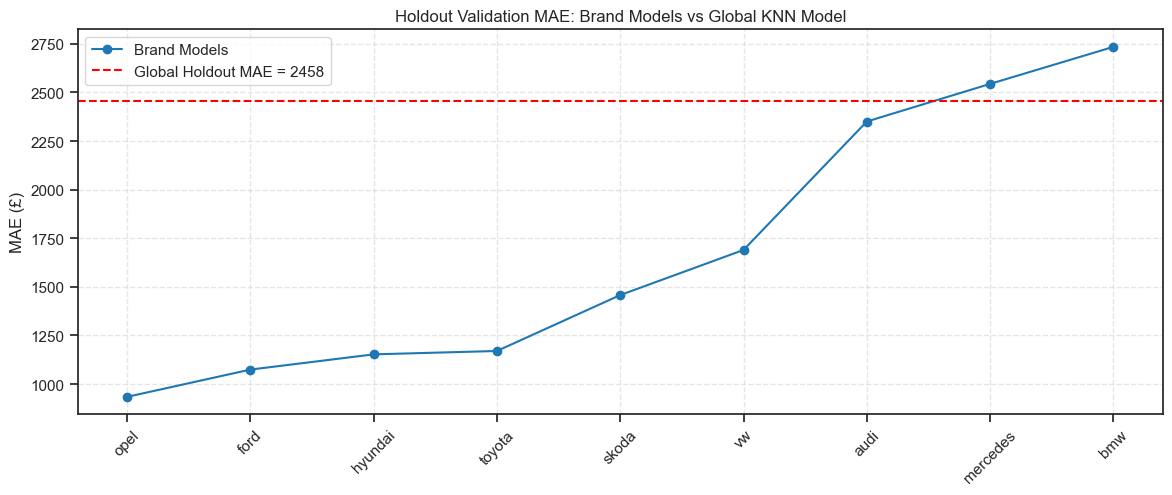

In [21]:
plt.figure(figsize=(14,5))
plt.plot(comparison_df['Brand'], comparison_df['Val MAE (Brand)'], marker='o', label='Brand Models')
plt.axhline(global_val_mae, color='red', linestyle='--', label=f'Global Holdout MAE = {global_val_mae:.0f}')

plt.title("Holdout Validation MAE: Brand Models vs Global KNN Model")
plt.ylabel("MAE (£)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


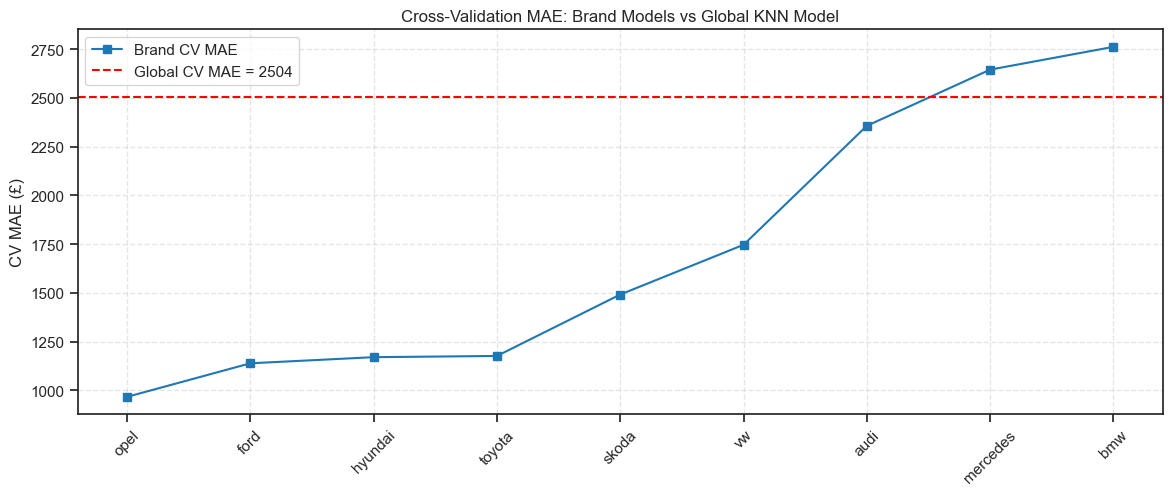

In [22]:

plt.figure(figsize=(14,5))
plt.plot(comparison_df['Brand'], comparison_df['CV Val MAE (Brand)'], marker='s', label='Brand CV MAE')
plt.axhline(global_cv_val_mae, color='red', linestyle='--', label=f'Global CV MAE = {global_cv_val_mae:.0f}')

plt.title("Cross-Validation MAE: Brand Models vs Global KNN Model")
plt.ylabel("CV MAE (£)")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()


# Random Forest

# NN

In [ ]:

# ----------------------------
# Define hyperparameter grids (use the ranges you indicated)
# ----------------------------
rf_param_grid = {
    'model__max_depth': list(range(4, 15)),       # 4..14
    'model__min_samples_split': [2, 5, 10]
}
knn_param_grid = {
    'model__n_neighbors': [3, 5, 7, 9],
    'model__weights': ['uniform', 'distance']
}
mlp_param_grid = {
    'model__hidden_layer_sizes': [(64,), (128,), (64, 32)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001]
}

# Helper: create GridSearchCV object
def make_gridsearch(pipeline, param_grid, cv=5, n_jobs=-1):
    return GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=n_jobs, verbose=0)

# ----------------------------
# 4) For each brand: run GridSearch on 3 models and evaluate on brand holdout (80/20 split)
# ----------------------------
brands = X_brand_source['Brand'].unique()
brands = np.sort(brands)
print(f"Found brands: {list(brands)}")

results = []

# We'll require a minimum number of samples to run stable CV; still we will run even for small sample sizes,
# but we will note sample count.
min_samples_warn = 30

for brand in brands:
    # Extract brand-specific X and y (make copies)
    mask = X_brand_source['Brand'] == brand
    X_b = X_brand_source.loc[mask].copy()
    y_b = y_brand_source.loc[mask].copy()
    n_samples = X_b.shape[0]
    print(f"\n=== Brand: {brand} — n_samples: {n_samples} ===")
    if n_samples < min_samples_warn:
        print(f"  WARNING: only {n_samples} samples for brand {brand}. CV results may be noisy.")
    # Keep brand column for splitting but remove before modeling (brand is not a feature)
    if 'Brand' in X_b.columns:
        X_b = X_b.drop(columns=['Brand'])
    # Fill missing transmission with stored mode (from your pipeline)
    # We prefer the mode you saved in the full preprocessing if available
    mode_to_use = mode_transmission_full if mode_transmission_full is not None else (X_b['transmission'].mode()[0] if 'transmission' in X_b.columns else None)
    if 'transmission' in X_b.columns and pd.isna(X_b['transmission']).sum() > 0:
        X_b['transmission'] = X_b['transmission'].fillna(mode_to_use)

    # Train/test split (brand-specific holdout)
    X_train, X_test, y_train, y_test = train_test_split(X_b, y_b, test_size=0.20, random_state=42)

    # Models to run
    model_specs = [
        ('DecisionTree', DecisionTreeRegressor(random_state=42), dt_param_grid),
        ('KNN', KNeighborsRegressor(), knn_param_grid),
        ('MLP', MLPRegressor(max_iter=2000, random_state=42), mlp_param_grid)
    ]

    for model_name, model_obj, param_grid in model_specs:
        pipe = make_pipeline(model_obj)
        grid = make_gridsearch(pipe, param_grid, cv=5, n_jobs=-1)
        # Fit
        try:
            grid.fit(X_train, y_train)
        except Exception as e:
            print(f"  ERROR fitting {model_name} for brand {brand}: {e}")
            continue
        # Best estimator predict on test
        y_pred_log = grid.predict(X_test)   # predictions are in log space
        # Convert to original price space
        y_test_price = np.exp(y_test)
        y_pred_price = np.exp(y_pred_log)
        mae_price = mean_absolute_error(y_test_price, y_pred_price)
        # Also provide MAE in log-space for debugging
        mae_log = mean_absolute_error(y_test, y_pred_log)

        results.append({
            'brand': brand,
            'n_samples': n_samples,
            'model': model_name,
            'best_params': grid.best_params_,
            'test_MAE_price': mae_price,
            'test_MAE_log': mae_log,
            'y_test_size': len(y_test)
        })
        print(f"  {model_name}: MAE(price)={mae_price:.2f}  MAE(log)={mae_log:.4f}")

# ----------------------------
# 5) Train the same models as 'general models' (global) and evaluate on your HO validation set
#    We'll use X_train_HO/X_val_HO (these are already preprocessed/scaled according to your pipeline)
# ----------------------------
# If HO set already preprocessed and scaled, we can use them directly with the model (skip preprocessing steps).
# But to keep parity with brand pipelines, we'll train using a pipeline that only contains the model step,
# because X_train_HO/X_val_HO look already numeric. If not numeric, fallback to re-creating the same preprocessor.

def train_general_and_eval(model_name, model_obj, param_grid):
    print(f"\nTraining general model: {model_name}")
    # Build a pipeline that assumes X_train_HO is already numeric (scaled/imputed)
    pipe = Pipeline([('model', model_obj)])
    grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    # Fit on HO train (which presumably is the prepared training set)
    try:
        grid.fit(X_train_HO, y_train_HO)
    except Exception as e:
        print(f"  ERROR fitting general {model_name}: {e}")
        return None
    y_val_pred_log = grid.predict(X_val_HO)
    y_val_price = np.exp(y_val_HO)
    y_val_pred_price = np.exp(y_val_pred_log)
    mae_price = mean_absolute_error(y_val_price, y_val_pred_price)
    mae_log = mean_absolute_error(y_val_HO, y_val_pred_log)
    print(f"  General {model_name}: HO MAE(price)={mae_price:.2f}  MAE(log)={mae_log:.4f}")
    return {
        'model': model_name,
        'best_params': grid.best_params_,
        'HO_test_MAE_price': mae_price,
        'HO_test_MAE_log': mae_log
    }

general_results = []
general_results.append(train_general_and_eval('DecisionTree', DecisionTreeRegressor(random_state=42), dt_param_grid))
general_results.append(train_general_and_eval('KNN', KNeighborsRegressor(), knn_param_grid))
general_results.append(train_general_and_eval('MLP', MLPRegressor(max_iter=2000, random_state=42), mlp_param_grid))

# ----------------------------
# 6) Compile results and compare brand-specific vs general
# ----------------------------
results_df = pd.DataFrame(results)
general_df = pd.DataFrame([r for r in general_results if r is not None])

# Merge to include general HO MAE for easy comparison per model
# Expand general_df so each brand row can see the global HO MAE
if not general_df.empty:
    # pivot general_df to have model->HO_test_MAE_price
    general_map = general_df.set_index('model')['HO_test_MAE_price'].to_dict()
    results_df['general_HO_MAE_price'] = results_df['model'].map(general_map)
    # flag whether brand-specific is better (smaller) than general
    results_df['brand_better_than_general'] = results_df['test_MAE_price'] < results_df['general_HO_MAE_price']
else:
    results_df['general_HO_MAE_price'] = np.nan
    results_df['brand_better_than_general'] = False

# Sort results for readability
results_df = results_df.sort_values(['brand', 'model']).reset_index(drop=True)

# Save results
out_csv = '../project_data/brand_specific_results.csv'
results_df.to_csv(out_csv, index=False)
print(f"\nSaved brand-specific results to: {out_csv}")

# Show summary
print("\n=== Summary table (top rows) ===")
display_columns = ['brand', 'n_samples', 'model', 'test_MAE_price', 'general_HO_MAE_price', 'brand_better_than_general']
print(results_df[display_columns].head(50))

# Save general results too
general_out = '../project_data/general_model_results.csv'
general_df.to_csv(general_out, index=False)
print(f"Saved general model results to: {general_out}")

# If you want to inspect full details:
results_df.head(200)
